In [41]:
import pandas as pd
import numpy as np
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [42]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [43]:
# read in the data
df = pd.read_csv("./../data/supervised_1_1.csv")

In [44]:
print(df.shape)
df.set_index('date', inplace=True)
df.head()

(7316300, 22)


,e5gas,weekday,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,...,rotterdam,brent,wti,eurusd,vehicles,state,station,global_mean,state_mean,num_days
date,,,,,,,,,,,,,,,,,,,,,
2014-05-16,1.536647,5,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.622837,109.424042,101.258553,1.369886,15211.0,10,0,1.546131,1.561237,0
2014-05-17,1.564000,6,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.622486,109.699997,101.669998,1.369580,9146.0,10,0,1.560708,1.578196,1
2014-05-18,1.569417,0,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.622136,109.699997,101.669998,1.369580,9843.0,10,0,1.564237,1.581731,2
2014-05-19,1.578167,1,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.621785,109.838928,102.008537,1.370161,13502.0,10,0,1.563935,1.581525,3
2014-05-20,1.599000,2,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.620475,109.522926,102.058907,1.368282,12876.0,10,0,1.566228,1.582620,4


In [45]:
# try removing the averages so as to not include endogenous variables on the rigth hand side
df.drop(['global_mean', 'state_mean', 'eurusd', 'vehicles'], axis=1, inplace=True)
print(df.shape)
df.head()

(7316300, 17)


,e5gas,weekday,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,total,rotterdam,brent,wti,state,station,num_days
date,,,,,,,,,,,,,,,,,
2014-05-16,1.536647,5,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622837,109.424042,101.258553,10,0,0
2014-05-17,1.564000,6,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622486,109.699997,101.669998,10,0,1
2014-05-18,1.569417,0,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622136,109.699997,101.669998,10,0,2
2014-05-19,1.578167,1,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.621785,109.838928,102.008537,10,0,3
2014-05-20,1.599000,2,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.620475,109.522926,102.058907,10,0,4


In [46]:
# replace the oil prices for the last 30 days with the predictions
oil = pd.read_csv('./../data/linear_oil_yhat.csv')

last_30 = ['2015-11-11', '2015-11-13', '2015-11-14', '2015-11-15', '2015-11-16', '2015-11-17', '2015-11-18',
          '2015-11-19', '2015-11-20', '2015-11-21', '2015-11-22', '2015-11-23', '2015-11-24', '2015-11-25',
          '2015-11-26', '2015-11-27', '2015-11-28', '2015-11-29', '2015-11-30', '2015-12-01', '2015-12-02',
          '2015-12-03', '2015-12-04', '2015-12-05', '2015-12-06', '2015-12-07', '2015-12-08', '2015-12-09',
          '2015-12-10', '2015-12-10']

for index, date in enumerate(last_30):
    df.loc[date, 'rotterdam'] = oil['rot_yhat'][index]
    df.loc[date, 'brent'] = oil['brent_yhat'][index]
    df.loc[date, 'wti'] = oil['wti_yhat'][index]

In [47]:
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_lag = 1
n_seq = 1
reframed = series_to_supervised(scaled, n_lag, n_seq)
# drop the values from the final day for each station
# var21(t-1) with global and state mean and eurusd and vehicles
reframed = reframed[reframed['var17(t-1)'] != 1]
# drop columns we don't want to predict
# (22,42) with global and state mean
reframed.drop(reframed.columns[list(range(18,34))], axis=1, inplace=True)
# reframed.drop(reframed.columns[list(range(23,43))], axis=1, inplace=True) <-- this might be wrong, used for t=2
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var1(t)
1,0.614797,0.833333,0.499847,0.451308,0.231638,0.0,0.0,0.0,0.0,0.0,0.0,0.837361,0.930292,0.921895,0.384615,0.0,0.000000,0.625740
2,0.625740,1.000000,0.499847,0.451308,0.231638,0.0,0.0,0.0,0.0,0.0,0.0,0.836386,0.933953,0.927822,0.384615,0.0,0.001742,0.627907
3,0.627907,0.000000,0.499847,0.451308,0.231638,0.0,0.0,0.0,0.0,0.0,0.0,0.835411,0.933953,0.927822,0.384615,0.0,0.003484,0.631408
4,0.631408,0.166667,0.499847,0.451308,0.231638,0.0,0.0,0.0,0.0,0.0,0.0,0.834437,0.935795,0.932700,0.384615,0.0,0.005226,0.639743
5,0.639743,0.333333,0.499847,0.451308,0.231638,0.0,0.0,0.0,0.0,0.0,0.0,0.830794,0.931604,0.933425,0.384615,0.0,0.006969,0.628407


In [48]:
# split into train and test sets
# now order needs to be by day rather than by station -- reorder by num_days
# var21(t-1) is num_days, var19(t-1) when no global or state mean, 17 without euro and vehicle
# var18(t-1) is station, same without global or state mean, 16 without euro and vehicle
n_seq = 1
reframed.sort_values(by=['var17(t-1)', 'var16(t-1)'], inplace=True)
day_30 = reframed['var17(t-1)'].unique()[-30]
train = reframed.loc[reframed['var17(t-1)'] < day_30]
test = reframed.loc[reframed['var17(t-1)'] >= day_30]

In [49]:
train_values = train.values
test_values = test.values
# split into input and outputs
train_X, train_y = train_values[:, :-n_seq], train_values[:, -n_seq]
test_X, test_y = test_values[:, :-n_seq], test_values[:, -n_seq]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6921856, 1, 17) (6921856,) (381720, 1, 17) (381720,)


Train on 6921856 samples, validate on 381720 samples
Epoch 1/10
 - 48s - loss: 0.0315 - val_loss: 0.0188
Epoch 2/10
 - 43s - loss: 0.0160 - val_loss: 0.0135
Epoch 3/10
 - 45s - loss: 0.0149 - val_loss: 0.0135
Epoch 4/10
 - 43s - loss: 0.0142 - val_loss: 0.0119
Epoch 5/10
 - 48s - loss: 0.0133 - val_loss: 0.0109
Epoch 6/10
 - 44s - loss: 0.0123 - val_loss: 0.0102
Epoch 7/10
 - 46s - loss: 0.0110 - val_loss: 0.0130
Epoch 8/10
 - 43s - loss: 0.0114 - val_loss: 0.0143
Epoch 9/10
 - 43s - loss: 0.0106 - val_loss: 0.0139
Epoch 10/10
 - 42s - loss: 0.0101 - val_loss: 0.0147


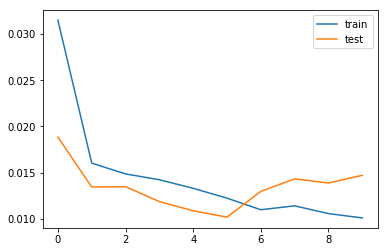

In [50]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(n_seq))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=7200, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [51]:
# make a prediction, however each new day must update the var(t-1) for the next day, which is e5gas(t-1)
# so we need to do this one day at a time
# also need to check the last day

yhat_days = {}
test_X_2 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
dtx = pd.DataFrame(data=test_X_2)
days = dtx[16].unique()
gas_before = []
for index, day in enumerate(days):
    print(index)
    df = dtx.loc[dtx[16] == day]
    if len(gas_before) > 0:
        df[0] = gas_before
    
    test_X_day = df.values
    test_X_day = test_X_day.reshape((test_X_day.shape[0], 1, test_X_day.shape[1]))
    yhat = model.predict(test_X_day)
    yhat_days[index] = yhat
    gas_before = yhat

0
1


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [52]:
# convert yhat to numpy array
yhat = np.array([])
for key, value in yhat_days.items():
    yhat = np.append(yhat, value)

In [53]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
yhat = yhat.reshape((len(yhat), 1))
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.141


In [31]:
yhat.shape

(381720, 1)

In [32]:
test_X[:, 1:].shape

(381720, 32)

In [34]:
inv_yhat.shape

(381720, 33)

In [54]:
inv_yhat

array([1.30802203, 1.28630458, 1.33120155, ..., 1.22196595, 1.26995869,
       1.16516941])

In [55]:
inv_y

array([1.324    , 1.3081667, 1.3631666, ..., 1.3056667, 1.3556666,
       1.2964998], dtype=float32)